In [2]:
#prepare problem
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import plotly.express as px
import matplotlib.pyplot as plt
from iso639 import languages
import user_agents
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo
import requests
import json
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from datasist.structdata import detect_outliers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

%matplotlib inline


In [6]:
df=pd.read_csv('t-shirts.csv')
df.head()


,Date ordered,Order number,Brand,Size,Color,Design,Price,Delivery status
0,2016-05-05,SDH-YU0,Yolo,L,red,spiral,14.47,damaged
1,2016-05-06,SDH-YU1,Yolo,XXL,green,spiral,16.24,delayed
2,2016-05-07,SDH-YU2,BLOT,XL,black,Stripes,14.32,delivered
3,2016-05-08,SDH-YU3,Kent,XXL,green,plain,14.07,damaged
4,2016-05-09,SDH-YU4,BUCK,XL,white,spiral,15.56,order received


In [5]:
""'''''
#def dataset_shape():
    print("head : ",df.head() )
    print("shape : ",df.shape )
    print("describe : ",df.describe() )
    print("describe categories : ",df.describe(include='O') )
    print("types : ",df.dtypes )
    print("null columns : ",df.isnull().sum() )
    print("info : ",df.info() )
    
''''''    
    
    
    
    

SyntaxError: EOF while scanning triple-quoted string literal (495102372.py, line 15)

In [7]:
df.shape

(500, 8)

In [8]:
df.dtypes

Date ordered        object
Order number        object
Brand               object
Size                object
Color               object
Design              object
Price              float64
Delivery status     object
dtype: object

In [10]:
df.describe()

,Price
count,500.000000
mean,15.016840
std,1.016292
min,12.240000
25%,14.307500
50%,14.990000
75%,15.622500
max,18.030000


In [11]:
df.describe(include='O')

,Date ordered,Order number,Brand,Size,Color,Design,Delivery status
count,500,500,500,500,500,500,500
unique,500,500,5,6,6,5,5
top,2016-05-05,SDH-YU0,Yolo,XXL,green,diamond,order received
freq,1,1,109,94,104,117,106


In [12]:
df.isnull().sum()

Date ordered       0
Order number       0
Brand              0
Size               0
Color              0
Design             0
Price              0
Delivery status    0
dtype: int64

In [13]:
df.duplicated().sum()

0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date ordered     500 non-null    object 
 1   Order number     500 non-null    object 
 2   Brand            500 non-null    object 
 3   Size             500 non-null    object 
 4   Color            500 non-null    object 
 5   Design           500 non-null    object 
 6   Price            500 non-null    float64
 7   Delivery status  500 non-null    object 
dtypes: float64(1), object(7)
memory usage: 31.4+ KB


In [19]:
df.drop(['order_number'],axis=1,inplace=True)
df.columns=df.columns.str.strip().str.lower()
df.columns=df.columns.str.replace(' ','_')
df.columns

Index(['date_ordered', 'brand', 'size', 'color', 'design', 'price',
       'delivery_status'],
      dtype='object')

In [23]:
#univariate analysis
lst=list(df.columns)
lst
for i in range(len(lst)) :
    fig=px.histogram(df,x=lst[i],title=f'for feature {lst[i]}',color_discrete_sequence=['blue'],text_auto=True,marginal='box')
    fig.show()

In [21]:
#bivariate analysis
for i in range(len(lst)) :
    for j in range(i+1,len(lst)) :
        fig=px.scatter(df,x=lst[i],y=lst[j],color_discrete_sequence=['pink'],title=f'for features {lst[i]} vs {lst[j]}')
        fig.show()

In [34]:
#prepare data 
#feature extraction
#domain knowledge feature
df['price'].value_counts()
df['price'].max()
df['price'].min()
df['price']=df['price'].astype(int)
df['price'].max()
df['price'].min()
def get_prob(x):
    if x <=18 and x >15 :
        return 'A'
    elif x <= 15 and x >=12 :
        return 'B'
    else :
        return 'NaN'
df['class']=df['price'].apply(get_prob)
df['class'].value_counts()
df

,date_ordered,brand,size,color,design,price,delivery_status,class
0,2016-05-05,Yolo,L,red,spiral,14,damaged,B
1,2016-05-06,Yolo,XXL,green,spiral,16,delayed,A
2,2016-05-07,BLOT,XL,black,Stripes,14,delivered,B
3,2016-05-08,Kent,XXL,green,plain,14,damaged,B
4,2016-05-09,BUCK,XL,white,spiral,15,order received,B
...,...,...,...,...,...,...,...,...
495,2017-09-12,Wang,XS,green,diamond,15,damaged,B
496,2017-09-13,BUCK,M,black,Stripes,14,shipping,B
497,2017-09-14,Kent,XXL,purple,plain,15,shipping,B
498,2017-09-15,Yolo,S,red,plain,13,order received,B


In [35]:
#data and time feature
df['date_ordered']=pd.to_datetime(df['date_ordered'],errors='coerce')
df['date_ordered'].dtype

dtype('<M8[ns]')

In [36]:
df['year']=(df['date_ordered'].dt.year).astype(int)
df['month']=(df['date_ordered'].dt.month).astype(int)
df['day']=(df['date_ordered'].dt.day).astype(int)
df['day_name']=df['date_ordered'].dt.day_name()
df

,date_ordered,brand,size,color,design,price,delivery_status,class,year,month,day,day_name
0,2016-05-05,Yolo,L,red,spiral,14,damaged,B,2016,5,5,Thursday
1,2016-05-06,Yolo,XXL,green,spiral,16,delayed,A,2016,5,6,Friday
2,2016-05-07,BLOT,XL,black,Stripes,14,delivered,B,2016,5,7,Saturday
3,2016-05-08,Kent,XXL,green,plain,14,damaged,B,2016,5,8,Sunday
4,2016-05-09,BUCK,XL,white,spiral,15,order received,B,2016,5,9,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2017-09-12,Wang,XS,green,diamond,15,damaged,B,2017,9,12,Tuesday
496,2017-09-13,BUCK,M,black,Stripes,14,shipping,B,2017,9,13,Wednesday
497,2017-09-14,Kent,XXL,purple,plain,15,shipping,B,2017,9,14,Thursday
498,2017-09-15,Yolo,S,red,plain,13,order received,B,2017,9,15,Friday


In [37]:
#string operations
#web data
#geo

In [38]:
#feature transformation
#cleansing
df.dtypes

date_ordered       datetime64[ns]
brand                      object
size                       object
color                      object
design                     object
price                       int32
delivery_status            object
class                      object
year                        int32
month                       int32
day                         int32
day_name                   object
dtype: object

In [44]:
df[df['price'] == 0]
df['year'].value_counts()
df['month'].value_counts()
df['day'].value_counts()
df['day_name'].value_counts()

Thursday     72
Friday       72
Saturday     72
Sunday       71
Monday       71
Tuesday      71
Wednesday    71
Name: day_name, dtype: int64

In [45]:
df[(df['month'] <1 ) | (df['month'] >12 )]

,date_ordered,brand,size,color,design,price,delivery_status,class,year,month,day,day_name


In [46]:
df[(df['day'] <1 ) | (df['day'] >31 )]

,date_ordered,brand,size,color,design,price,delivery_status,class,year,month,day,day_name


In [48]:
#check missing data
df.isnull().sum()

date_ordered       0
brand              0
size               0
color              0
design             0
price              0
delivery_status    0
class              0
year               0
month              0
day                0
day_name           0
dtype: int64

In [49]:
lst=[]
for i in df.columns :
    if df[i].dtype == 'int32':
        lst.append(i)
lst        

['price', 'year', 'month', 'day']

<AxesSubplot:xlabel='price'>

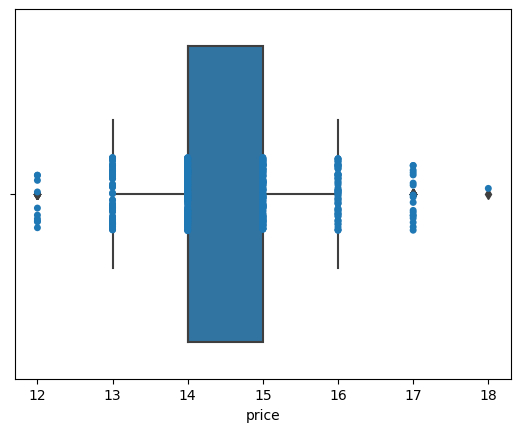

In [51]:
sns.boxplot(data=df,x='price')
sns.stripplot(data=df,x='price')

In [53]:
outliers_indices=detect_outliers(df,0,['price'])

df.drop(outliers_indices,inplace=True)

<AxesSubplot:xlabel='price'>

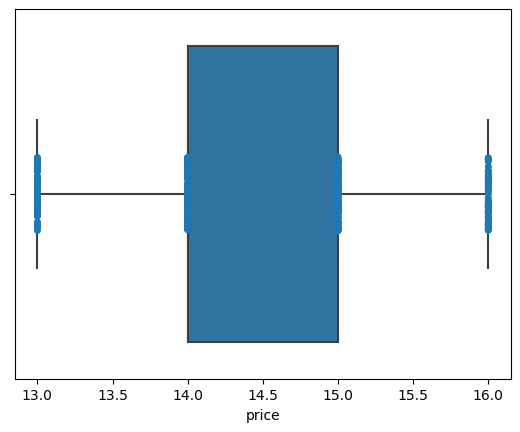

In [54]:
sns.boxplot(data=df,x='price')
sns.stripplot(data=df,x='price')

In [55]:
#work with categorical data
df.dtypes

date_ordered       datetime64[ns]
brand                      object
size                       object
color                      object
design                     object
price                       int32
delivery_status            object
class                      object
year                        int32
month                       int32
day                         int32
day_name                   object
dtype: object

In [56]:
lst=[]
#for col in df.select_dtypes('object').columns:
#lst.append(col)
for i in df.columns:
    if df[i].dtype == 'object':
        lst.append(i)
lst    

['brand', 'size', 'color', 'design', 'delivery_status', 'class', 'day_name']

In [57]:
df

,date_ordered,brand,size,color,design,price,delivery_status,class,year,month,day,day_name
0,2016-05-05,Yolo,L,red,spiral,14,damaged,B,2016,5,5,Thursday
1,2016-05-06,Yolo,XXL,green,spiral,16,delayed,A,2016,5,6,Friday
2,2016-05-07,BLOT,XL,black,Stripes,14,delivered,B,2016,5,7,Saturday
3,2016-05-08,Kent,XXL,green,plain,14,damaged,B,2016,5,8,Sunday
4,2016-05-09,BUCK,XL,white,spiral,15,order received,B,2016,5,9,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2017-09-12,Wang,XS,green,diamond,15,damaged,B,2017,9,12,Tuesday
496,2017-09-13,BUCK,M,black,Stripes,14,shipping,B,2017,9,13,Wednesday
497,2017-09-14,Kent,XXL,purple,plain,15,shipping,B,2017,9,14,Thursday
498,2017-09-15,Yolo,S,red,plain,13,order received,B,2017,9,15,Friday


In [58]:
#work with ordinal data
df['size'].value_counts()

XXL    89
XS     81
S      80
M      80
L      71
XL     70
Name: size, dtype: int64

In [63]:
size_dict={
    
    'XS' : 1,
    'S' : 2 ,
    'M' : 3,
    'L' : 4,
    'XL' : 5 , 
    'XXL' : 6   
    
    
}
size_class={
    
    'A':1,
    'B':2
}
df['size']=df['size'].map(size_dict)
df['class']=df['class'].map(size_class)

In [60]:
'''''''''''
lst=list(df['size'].unique())
def get_size(x):
    if x in lst :
        if x  == 'XS' : 
            return 1
        elif x == 'S' : 
            return 2 
        elif x == 'M' : 
            return 3
        elif x == 'L' : 
            return 4
        elif x == 'XL' : 
            return 5 
        elif x == 'XXL' : 
            return 6  
    else :
        return 'NaN'
df['size']=df['size'].apply(get_size)    
''''''''

SyntaxError: EOF while scanning triple-quoted string literal (3106583117.py, line 20)

In [61]:
"""""""""
lst=list(df['class'].unique())
def get_class(x):
    if x in lst :
        if x  == 'A' : 
            return 1
        elif x == 'B' : 
            return 2 
    else :
        return 'NaN'
df['class']=df['class'].apply(get_class)  

SyntaxError: EOF while scanning triple-quoted string literal (2934339357.py, line 11)

In [64]:
df

,date_ordered,brand,size,color,design,price,delivery_status,class,year,month,day,day_name
0,2016-05-05,Yolo,4,red,spiral,14,damaged,2,2016,5,5,Thursday
1,2016-05-06,Yolo,6,green,spiral,16,delayed,1,2016,5,6,Friday
2,2016-05-07,BLOT,5,black,Stripes,14,delivered,2,2016,5,7,Saturday
3,2016-05-08,Kent,6,green,plain,14,damaged,2,2016,5,8,Sunday
4,2016-05-09,BUCK,5,white,spiral,15,order received,2,2016,5,9,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
495,2017-09-12,Wang,1,green,diamond,15,damaged,2,2017,9,12,Tuesday
496,2017-09-13,BUCK,3,black,Stripes,14,shipping,2,2017,9,13,Wednesday
497,2017-09-14,Kent,6,purple,plain,15,shipping,2,2017,9,14,Thursday
498,2017-09-15,Yolo,2,red,plain,13,order received,2,2017,9,15,Friday


In [137]:
#work with nominal
#one hot encoding
df_new=df
lst=[]
#for col in df.select_dtypes('object').columns:
#lst.append(col)
for i in df.columns:
    if df[i].dtype == 'object':
        lst.append(i)
lst  
lst_small=['brand', 'color', 'design', 'delivery_status']
df_new=pd.get_dummies(df,columns=lst_small,drop_first=True)

df_new


,size,price,class,year,month,day,day_name,brand_BUCK,brand_Kent,brand_Wang,...,color_red,color_white,design_checked,design_diamond,design_plain,design_spiral,delivery_status_delayed,delivery_status_delivered,delivery_status_order received,delivery_status_shipping
0,4,14,2,2016,5,5,Thursday,0,0,0,...,1,0,0,0,0,1,0,0,0,0
1,6,16,1,2016,5,6,Friday,0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,5,14,2,2016,5,7,Saturday,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,6,14,2,2016,5,8,Sunday,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,5,15,2,2016,5,9,Monday,1,0,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,15,2,2017,9,12,Tuesday,0,0,1,...,0,0,0,1,0,0,0,0,0,0
496,3,14,2,2017,9,13,Wednesday,1,0,0,...,0,0,0,0,0,0,0,0,0,1
497,6,15,2,2017,9,14,Thursday,0,1,0,...,0,0,0,0,1,0,0,0,0,1
498,2,13,2,2017,9,15,Friday,0,0,0,...,1,0,0,0,1,0,0,0,1,0


In [138]:
#binary encoding
lst_big=['day_name']
#df_new.drop(['date_ordered'],axis=1,inplace=True)
for i in lst_big :
    ce_bin=ce.BinaryEncoder()
    y=ce_bin.fit_transform(df_new[[i]])
    df_new=pd.concat([df_new,y],axis=1)
    df_new.drop([i],axis=1,inplace=True)
df_new.dtypes  
df_new

,size,price,class,year,month,day,brand_BUCK,brand_Kent,brand_Wang,brand_Yolo,...,design_diamond,design_plain,design_spiral,delivery_status_delayed,delivery_status_delivered,delivery_status_order received,delivery_status_shipping,day_name_0,day_name_1,day_name_2
0,4,14,2,2016,5,5,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
1,6,16,1,2016,5,6,0,0,0,1,...,0,0,1,1,0,0,0,0,1,0
2,5,14,2,2016,5,7,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
3,6,14,2,2016,5,8,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5,15,2,2016,5,9,1,0,0,0,...,0,0,1,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,15,2,2017,9,12,0,0,1,0,...,1,0,0,0,0,0,0,1,1,0
496,3,14,2,2017,9,13,1,0,0,0,...,0,0,0,0,0,0,1,1,1,1
497,6,15,2,2017,9,14,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
498,2,13,2,2017,9,15,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0


In [139]:
df_new.dtypes
#check of there is categorical data left
lst_1=[]
#for i in df_new.select_dtypes('object').columns :
#lst_1.append(i)
for i in df_new.columns:
    if df_new[i].dtype == 'object':
        lst_1.append(i)
lst_1  

[]

In [140]:
#splitting data and balancing classes
#collect imbalanced classes in list
for i in df_new.columns:
    print(f"for feature {i} : \n")
    #print(df_new[i].value_counts())
    print(df_new.groupby(i).size())
    fig=px.pie(df_new,names=i)
    fig.show()

for feature size : 

size
1    81
2    80
3    80
4    71
5    70
6    89
dtype: int64


for feature price : 

price
13     66
14    175
15    165
16     65
dtype: int64


for feature class : 

class
1     65
2    406
dtype: int64


for feature year : 

year
2016    227
2017    244
dtype: int64


for feature month : 

month
1     29
2     25
3     30
4     29
5     56
6     58
7     58
8     59
9     41
10    30
11    27
12    29
dtype: int64


for feature day : 

day
1     15
2     15
3     13
4     15
5     15
6     17
7     17
8     15
9     17
10    16
11    17
12    16
13    14
14    17
15    17
16    17
17    16
18    14
19    16
20    15
21    15
22    16
23    14
24    15
25    15
26    15
27    12
28    16
29    15
30    14
31    10
dtype: int64


for feature brand_BUCK : 

brand_BUCK
0    375
1     96
dtype: int64


for feature brand_Kent : 

brand_Kent
0    371
1    100
dtype: int64


for feature brand_Wang : 

brand_Wang
0    374
1     97
dtype: int64


for feature brand_Yolo : 

brand_Yolo
0    368
1    103
dtype: int64


for feature color_green : 

color_green
0    374
1     97
dtype: int64


for feature color_indigo : 

color_indigo
0    389
1     82
dtype: int64


for feature color_purple : 

color_purple
0    398
1     73
dtype: int64


for feature color_red : 

color_red
0    395
1     76
dtype: int64


for feature color_white : 

color_white
0    403
1     68
dtype: int64


for feature design_checked : 

design_checked
0    369
1    102
dtype: int64


for feature design_diamond : 

design_diamond
0    366
1    105
dtype: int64


for feature design_plain : 

design_plain
0    395
1     76
dtype: int64


for feature design_spiral : 

design_spiral
0    386
1     85
dtype: int64


for feature delivery_status_delayed : 

delivery_status_delayed
0    380
1     91
dtype: int64


for feature delivery_status_delivered : 

delivery_status_delivered
0    383
1     88
dtype: int64


for feature delivery_status_order received : 

delivery_status_order received
0    371
1    100
dtype: int64


for feature delivery_status_shipping : 

delivery_status_shipping
0    373
1     98
dtype: int64


for feature day_name_0 : 

day_name_0
0    201
1    270
dtype: int64


for feature day_name_1 : 

day_name_1
0    199
1    272
dtype: int64


for feature day_name_2 : 

day_name_2
0    204
1    267
dtype: int64


In [141]:
#splitting and balancing
x=df_new.drop(['class'],axis=1)
y=df_new['class']
print()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle=True)
print("-------------------------------------------------\n")
x_train


-------------------------------------------------



,size,price,year,month,day,brand_BUCK,brand_Kent,brand_Wang,brand_Yolo,color_green,...,design_diamond,design_plain,design_spiral,delivery_status_delayed,delivery_status_delivered,delivery_status_order received,delivery_status_shipping,day_name_0,day_name_1,day_name_2
378,2,14,2017,5,18,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
41,4,14,2016,6,15,0,0,0,0,0,...,1,0,0,1,0,0,0,1,1,1
210,2,14,2016,12,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
77,4,13,2016,7,21,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
487,4,16,2017,9,4,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,4,15,2017,8,2,0,1,0,0,0,...,0,0,1,0,0,1,0,1,1,1
377,6,14,2017,5,17,0,0,0,1,1,...,0,1,0,0,1,0,0,1,1,1
204,4,13,2016,11,25,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
88,3,15,2016,8,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1


In [142]:
x_test

,size,price,year,month,day,brand_BUCK,brand_Kent,brand_Wang,brand_Yolo,color_green,...,design_diamond,design_plain,design_spiral,delivery_status_delayed,delivery_status_delivered,delivery_status_order received,delivery_status_shipping,day_name_0,day_name_1,day_name_2
329,4,15,2017,3,30,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
18,1,15,2016,5,23,0,0,1,0,1,...,0,0,0,0,0,0,1,1,0,1
485,3,16,2017,9,2,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,1
373,6,15,2017,5,13,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
42,2,15,2016,6,16,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,4,16,2017,8,8,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
417,6,13,2017,6,26,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
24,5,14,2016,5,29,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
58,1,15,2016,7,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1


In [143]:
y_train
y_train.value_counts()

2    322
1     54
Name: class, dtype: int64

In [144]:
y_test

329    2
18     2
485    1
373    2
42     2
      ..
460    1
417    2
24     2
58     2
164    2
Name: class, Length: 95, dtype: int64

In [145]:
#sampling
over=RandomOverSampler()
x_train,y_train=over.fit_resample(x_train,y_train)
y_train.value_counts()

2    322
1    322
Name: class, dtype: int64

In [146]:
# data leakage 
#feature scaling
#standarization
scaler=StandardScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train[x_train.columns])

In [147]:
x_train

,size,price,year,month,day,brand_BUCK,brand_Kent,brand_Wang,brand_Yolo,color_green,...,design_diamond,design_plain,design_spiral,delivery_status_delayed,delivery_status_delivered,delivery_status_order received,delivery_status_shipping,day_name_0,day_name_1,day_name_2
0,-0.895302,-1.091687,0.936777,-0.492555,0.298718,-0.498058,-0.570178,-0.473640,-0.555826,2.203303,...,-0.577350,-0.433811,-0.466252,-0.495629,-0.443876,1.914854,-0.527046,-1.080902,-1.231107,0.830836
1,0.227531,-1.091687,-1.067490,-0.173435,-0.056653,-0.498058,-0.570178,-0.473640,-0.555826,-0.453864,...,1.732051,-0.433811,-0.466252,2.017639,-0.443876,-0.522233,-0.527046,0.925153,0.812277,0.830836
2,-0.895302,-1.091687,-1.067490,1.741287,-1.715055,-0.498058,1.753838,-0.473640,-0.555826,-0.453864,...,-0.577350,2.305152,-0.466252,-0.495629,-0.443876,-0.522233,-0.527046,-1.080902,-1.231107,0.830836
3,0.227531,-2.073595,-1.067490,0.145685,0.654090,-0.498058,-0.570178,-0.473640,-0.555826,-0.453864,...,-0.577350,2.305152,-0.466252,-0.495629,-0.443876,1.914854,-0.527046,-1.080902,-1.231107,0.830836
4,0.227531,0.872130,0.936777,0.783926,-1.359683,-0.498058,1.753838,-0.473640,-0.555826,-0.453864,...,1.732051,-0.433811,-0.466252,-0.495629,-0.443876,1.914854,-0.527046,0.925153,-1.231107,0.830836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,-0.895302,0.872130,-1.067490,1.422167,0.654090,-0.498058,1.753838,-0.473640,-0.555826,-0.453864,...,-0.577350,2.305152,-0.466252,-0.495629,-0.443876,1.914854,-0.527046,0.925153,-1.231107,0.830836
640,-1.456719,0.872130,0.936777,-1.769037,-0.530483,2.007797,-0.570178,-0.473640,-0.555826,-0.453864,...,-0.577350,-0.433811,-0.466252,2.017639,-0.443876,-0.522233,-0.527046,0.925153,0.812277,0.830836
641,1.350364,0.872130,-1.067490,0.145685,1.246376,-0.498058,-0.570178,-0.473640,1.799123,2.203303,...,-0.577350,2.305152,-0.466252,2.017639,-0.443876,-0.522233,-0.527046,0.925153,0.812277,-1.203607
642,-0.895302,0.872130,-1.067490,0.145685,1.127919,-0.498058,-0.570178,-0.473640,-0.555826,-0.453864,...,-0.577350,-0.433811,-0.466252,-0.495629,2.252881,-0.522233,-0.527046,0.925153,-1.231107,0.830836


In [148]:
x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

In [149]:
x_test

,size,price,year,month,day,brand_BUCK,brand_Kent,brand_Wang,brand_Yolo,color_green,...,design_diamond,design_plain,design_spiral,delivery_status_delayed,delivery_status_delivered,delivery_status_order received,delivery_status_shipping,day_name_0,day_name_1,day_name_2
329,0.227531,-0.109779,0.936777,-1.130796,1.720205,-0.498058,-0.570178,-0.473640,1.799123,-0.453864,...,-0.577350,-0.433811,-0.466252,-0.495629,-0.443876,-0.522233,-0.527046,-1.080902,-1.231107,0.830836
18,-1.456719,-0.109779,-1.067490,-0.492555,0.891005,-0.498058,-0.570178,2.111309,-0.555826,2.203303,...,-0.577350,-0.433811,-0.466252,-0.495629,-0.443876,-0.522233,1.897367,0.925153,-1.231107,0.830836
485,-0.333886,0.872130,0.936777,0.783926,-1.596598,-0.498058,-0.570178,-0.473640,-0.555826,-0.453864,...,-0.577350,-0.433811,2.144761,-0.495629,-0.443876,-0.522233,1.897367,-1.080902,0.812277,0.830836
373,1.350364,-0.109779,0.936777,-0.492555,-0.293568,-0.498058,1.753838,-0.473640,-0.555826,2.203303,...,-0.577350,-0.433811,-0.466252,-0.495629,-0.443876,-0.522233,-0.527046,-1.080902,0.812277,0.830836
42,-0.895302,-0.109779,-1.067490,-0.173435,0.061804,-0.498058,-0.570178,2.111309,-0.555826,-0.453864,...,1.732051,-0.433811,-0.466252,-0.495629,-0.443876,-0.522233,-0.527046,-1.080902,-1.231107,0.830836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,0.227531,0.872130,0.936777,0.464806,-0.885854,-0.498058,-0.570178,-0.473640,-0.555826,-0.453864,...,-0.577350,2.305152,-0.466252,-0.495629,-0.443876,1.914854,-0.527046,0.925153,0.812277,-1.203607
417,1.350364,-2.073595,0.936777,-0.173435,1.246376,-0.498058,-0.570178,-0.473640,1.799123,-0.453864,...,-0.577350,2.305152,-0.466252,-0.495629,2.252881,-0.522233,-0.527046,0.925153,-1.231107,0.830836
24,0.788947,-1.091687,-1.067490,-0.492555,1.601748,-0.498058,-0.570178,-0.473640,1.799123,-0.453864,...,-0.577350,-0.433811,-0.466252,-0.495629,-0.443876,-0.522233,1.897367,0.925153,-1.231107,-1.203607
58,-1.456719,-0.109779,-1.067490,0.145685,-1.596598,-0.498058,-0.570178,-0.473640,-0.555826,-0.453864,...,-0.577350,-0.433811,2.144761,-0.495629,-0.443876,-0.522233,-0.527046,-1.080902,0.812277,0.830836


In [ ]:
#i thought it is catchy dataset for more challanges like sampling like making techniques perfect
#i choose this because it is challengble to me 
#my conclusion that over sampling is the best to imbalanced clases , must converting all training and test set to numeric values,better to drop outliers
#we user one column as traget and make all sampling ,splitting,scaling based on it 
#we canot fit data set if it is not all numeric
#no need to let the date data column to be left as long as you extract what o you want from it
#no need for unnecesarry columns